# Phase 2.1 — Topic Modeling ด้วย NMF (Non-negative Matrix Factorization)

**วิชา:** Introduction to Natural Language Processing  
**Dataset:** Financial & Business News (6,095 ประโยค)  
**เป้าหมาย:** ค้นหา Topic ที่ซ่อนอยู่ในข้อมูลแบบ Unsupervised โดยไม่ต้อง label ข้อมูลเอง

## 0. ติดตั้ง Library ที่จำเป็น

In [1]:
# ติดตั้ง library ที่อาจยังไม่มีในเครื่อง
# !pip install scikit-learn nltk pandas matplotlib seaborn wordcloud pyLDAvis

## 1. Import Libraries

In [29]:
# === Standard Libraries ===
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

# === NLP Libraries ===
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# === Scikit-learn: TF-IDF + NMF ===
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# === Visualization ===
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from wordcloud import WordCloud
from tabulate import tabulate

# ดาวน์โหลด resource ที่จำเป็นของ NLTK
nltk.download('stopwords', quiet=True)
nltk.download('wordnet',   quiet=True)
nltk.download('punkt',     quiet=True)
nltk.download('punkt_tab', quiet=True)

print("✅ Import สำเร็จทั้งหมด")

✅ Import สำเร็จทั้งหมด


## 2. โหลดข้อมูล (Load Data)

In [ ]:
# โหลด dataset จากไฟล์ CSV
df = pd.read_csv('clean_text_(Web_Scraping).csv')

# ตรวจสอบโครงสร้างข้อมูลเบื้องต้น
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nNull values:\n{df.isnull().sum()}")
print(f"\nตัวอย่างข้อมูล 3 แถวแรก:")
df.head(3)

Shape: (856, 1)
Columns: ['Sentence']

Null values:
Sentence    0
dtype: int64

ตัวอย่างข้อมูล 3 แถวแรก:


,Sentence
0,Could Intuitive Surgical Be the One Medtech St...
1,"Gold prices bounce back above 5,000 on safe ha..."
2,Hawkish hints in Fed minutes; Walmart to repor...


สถิติความยาวข้อความ (จำนวนคำ):
count    856.00
mean      62.45
std       59.53
min       10.00
25%       19.00
50%       30.50
75%       89.00
max      195.00
Name: word_count, dtype: float64


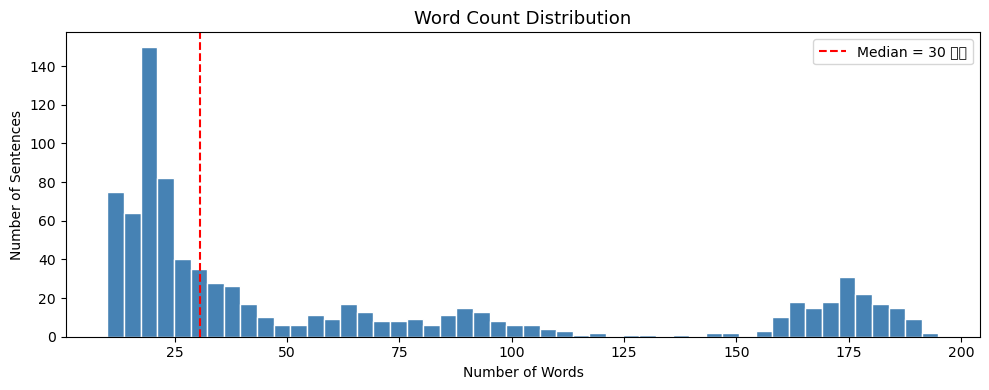

In [4]:
# ตรวจสอบการกระจายความยาวของข้อความ (จำนวนคำต่อประโยค)
df['word_count'] = df['Sentence'].str.split().str.len()

print("สถิติความยาวข้อความ (จำนวนคำ):")
print(df['word_count'].describe().round(2))

# Plot histogram
plt.figure(figsize=(10, 4))
plt.hist(df['word_count'], bins=50, color='steelblue', edgecolor='white')
plt.axvline(df['word_count'].median(), color='red', linestyle='--', label=f"Median = {df['word_count'].median():.0f} คำ")
plt.title('Word Count Distribution', fontsize=13)
plt.xlabel('Number of Words')
plt.ylabel('Number of Sentences')
plt.legend()
plt.tight_layout()
plt.show()

## 3. Preprocessing Pipeline

ทำความสะอาดข้อมูลก่อน vectorize เพื่อให้โมเดลได้คำที่มีความหมายจริงๆ

In [5]:
# เตรียม Stopwords และ Lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# เพิ่ม stopwords เฉพาะโดเมน Finance ที่ไม่ค่อยมีความหมายสำหรับ Topic
# เช่น คำทั่วไปที่ปรากฏในทุก Topic จนไม่ช่วยแยกแยะ
custom_stopwords = {
    'said', 'say', 'year', 'also', 'would', 'could', 'may',
    'one', 'new', 'last', 'first', 'two', 'three', 'million',
    'billion', 'percent', 'quarter', 'week', 'month', 'day',
    'time', 'company', 'reuters', 'inc', 'corp', 'ltd'
}
stop_words.update(custom_stopwords)


def preprocess_text(text):
    """
    Pipeline ทำความสะอาดข้อความ:
    1. lowercase
    2. ลบ HTML tags, URLs, อีเมล, ตัวเลข, และอักขระพิเศษ
    3. Tokenize
    4. ลบ Stopwords และคำสั้นมาก (< 3 ตัวอักษร)
    5. Lemmatization (แปลงคำให้เป็นรูปฐาน เช่น running → run)
    """
    # 1. แปลงเป็นตัวพิมพ์เล็กทั้งหมด
    text = text.lower()

    # 2. ลบ HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # 3. ลบ URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # 4. ลบอีเมล
    text = re.sub(r'[\w\.-]+@[\w\.-]+', '', text)

    # 5. ลบตัวเลขและอักขระพิเศษ เหลือแต่ตัวอักษรและช่องว่าง
    text = re.sub(r'[^a-z\s]', '', text)

    # 6. ลบ whitespace ซ้ำ
    text = re.sub(r'\s+', ' ', text).strip()

    # 7. Tokenize แยกเป็นคำ
    tokens = word_tokenize(text)

    # 8. ลบ Stopwords และคำที่สั้นเกินไป (น้อยกว่า 3 ตัวอักษร)
    tokens = [t for t in tokens if t not in stop_words and len(t) >= 3]

    # 9. Lemmatization: แปลงคำให้เป็นรูปฐาน
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return ' '.join(tokens)


# ใช้ Pipeline กับทุกแถวใน DataFrame
print("กำลัง Preprocess ข้อมูล...")
df['cleaned'] = df['Sentence'].apply(preprocess_text)

# ลบแถวที่ข้อความหลัง clean แล้วสั้นเกินไป (น้อยกว่า 3 คำ)
df = df[df['cleaned'].str.split().str.len() >= 3].reset_index(drop=True)

print(f"✅ Preprocess เสร็จแล้ว | จำนวนข้อมูลที่ใช้ได้: {len(df):,} แถว")
print("\nตัวอย่างก่อน / หลัง Preprocess:")
for i in range(3):
    print(f"\n[Original] {df['Sentence'].iloc[i][:100]}")
    print(f"[Cleaned]  {df['cleaned'].iloc[i][:100]}")

กำลัง Preprocess ข้อมูล...
✅ Preprocess เสร็จแล้ว | จำนวนข้อมูลที่ใช้ได้: 856 แถว

ตัวอย่างก่อน / หลัง Preprocess:

[Original] Could Intuitive Surgical Be the One Medtech Stock to Hold Through Any Market Crash?. This stock has 
[Cleaned]  intuitive surgical medtech stock hold market crash stock climbed triple digit recent year

[Original] Gold prices bounce back above 5,000 on safe haven demand. Geopolitical tensions between the US and I
[Cleaned]  gold price bounce back safe demand geopolitical tension iran drive investor precious metal

[Original] Hawkish hints in Fed minutes; Walmart to report - what s moving markets. Investing.com - Futures lin
[Cleaned]  hawkish hint fed minute walmart report moving market investingcom future linked main stock index ris


## 4. TF-IDF Vectorization

NMF ต้องการ Matrix เป็น Input โดย TF-IDF จะแปลงข้อความเป็น Matrix ขนาด (n_docs × n_words)  
แต่ละค่าในตารางแสดงว่าคำนั้น "สำคัญ" แค่ไหนในแต่ละ document

In [6]:
# สร้าง TF-IDF Vectorizer
# - max_features: ใช้แค่ 5,000 คำที่พบบ่อยที่สุด เพื่อลด noise
# - max_df: ตัดคำที่ปรากฏใน document มากกว่า 90% ออก (คำที่พบบ่อยเกินไปไม่ช่วย distinguish topic)
# - min_df: ตัดคำที่ปรากฏน้อยกว่า 5 ครั้งออก (คำที่หายากเกินไปก็ไม่ช่วย)
# - ngram_range: ใช้ทั้ง unigram (1 คำ) และ bigram (2 คำ) เช่น "interest rate", "stock market"
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    max_df=0.90,
    min_df=5,
    ngram_range=(1, 2)
)

# แปลงข้อความทั้งหมดเป็น TF-IDF Matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned'])

# ดึงชื่อ Feature (คำ) ทั้งหมด
feature_names = tfidf_vectorizer.get_feature_names_out()

print(f"TF-IDF Matrix shape: {tfidf_matrix.shape}")
print(f"→ {tfidf_matrix.shape[0]:,} documents × {tfidf_matrix.shape[1]:,} terms")
print(f"\nตัวอย่าง Feature (คำ) แรก 20 คำ:")
print(feature_names[:20].tolist())

TF-IDF Matrix shape: (856, 1501)
→ 856 documents × 1,501 terms

ตัวอย่าง Feature (คำ) แรก 20 คำ:
['aapl', 'ability', 'accelerating', 'access', 'according', 'account', 'acquisition', 'acre', 'across', 'action', 'action check', 'active', 'activist', 'activity', 'actually', 'add', 'added', 'adding', 'addition', 'additional']


## 5. เลือกจำนวน Topic ที่เหมาะสม (Optimal k)

ใช้ **Reconstruction Error** เป็นตัวชี้วัด ยิ่ง k มากขึ้น Error จะลด  
เราจะหาจุดที่ Error เริ่ม "ลดช้าลง" (Elbow Point) ซึ่งเป็น k ที่เหมาะสม

กำลังคำนวณ Reconstruction Error สำหรับแต่ละค่า k...
  k= 3 → Reconstruction Error = 28.5806
  k= 4 → Reconstruction Error = 28.4463
  k= 5 → Reconstruction Error = 28.3225
  k= 6 → Reconstruction Error = 28.2061
  k= 7 → Reconstruction Error = 28.0987
  k= 8 → Reconstruction Error = 27.9894
  k= 9 → Reconstruction Error = 27.8906
  k=10 → Reconstruction Error = 27.7870
  k=11 → Reconstruction Error = 27.6962


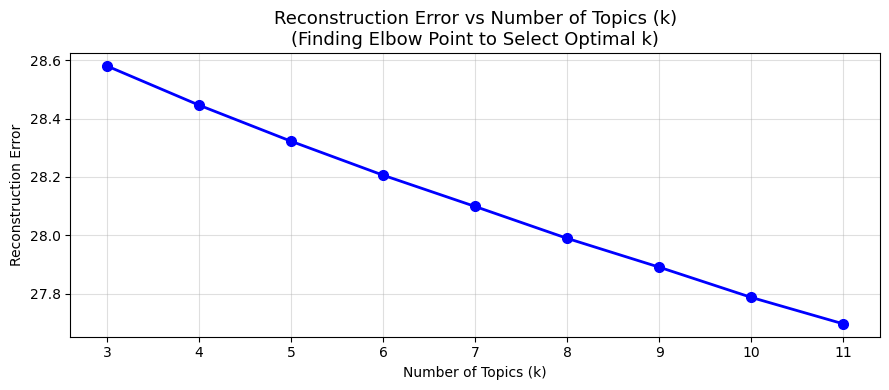


💡 ดูที่กราฟ: เลือก k ณ จุดที่เส้นกราฟเริ่มแบน (Elbow Point)


In [7]:
# ทดลองหลายค่า k ตามที่โปรเจคกำหนด (5–10)
k_range = range(3, 12)  # ลองกว้างหน่อยเพื่อเห็นภาพ Elbow ชัดขึ้น
errors = []

print("กำลังคำนวณ Reconstruction Error สำหรับแต่ละค่า k...")
for k in k_range:
    nmf_temp = NMF(
        n_components=k,
        random_state=42,
        init='nndsvda',      # initialization ที่ดีสำหรับ sparse data
        max_iter=300
    )
    nmf_temp.fit(tfidf_matrix)
    errors.append(nmf_temp.reconstruction_err_)
    print(f"  k={k:2d} → Reconstruction Error = {nmf_temp.reconstruction_err_:.4f}")


# Plot Elbow Curve
plt.figure(figsize=(9, 4))
plt.plot(list(k_range), errors, 'bo-', linewidth=2, markersize=7)
plt.title('Reconstruction Error vs Number of Topics (k)\n(Finding Elbow Point to Select Optimal k)', fontsize=13)
plt.xlabel('Number of Topics (k)')
plt.ylabel('Reconstruction Error')
plt.xticks(list(k_range))
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

print("\n💡 ดูที่กราฟ: เลือก k ณ จุดที่เส้นกราฟเริ่มแบน (Elbow Point)")

## 6. Train NMF Model

In [8]:
# ======================================================
# กำหนดจำนวน Topic ที่ต้องการ (ปรับได้ตามผล Elbow Curve)
# ค่าเริ่มต้น: 7 topics (อยู่ในช่วง 5-10 ตามที่โปรเจคกำหนด)
# ======================================================
N_TOPICS = 7

# Train NMF Model
# - init='nndsvda': วิธีตั้งค่าเริ่มต้น ดีกับข้อมูล sparse
# - random_state=42: กำหนด seed เพื่อให้ผลออกมาเหมือนเดิมทุกครั้ง
# - max_iter=500: จำนวนรอบ iteration สูงสุด
# - l1_ratio=0.1: ผสม L1 regularization เล็กน้อย เพื่อให้ได้ topic ที่ sparse กว่า (คมกว่า)
nmf_model = NMF(
    n_components=N_TOPICS,
    init='nndsvda',
    random_state=42,
    max_iter=500,
    l1_ratio=0.1
)

# W: Document-Topic Matrix (shape: n_docs × n_topics)
#    แต่ละแถวบอกว่า document นั้นเกี่ยวข้องกับ topic ไหนมากแค่ไหน
W = nmf_model.fit_transform(tfidf_matrix)

# H: Topic-Word Matrix (shape: n_topics × n_words)
#    แต่ละแถวบอกว่า topic นั้นประกอบด้วยคำอะไรบ้าง
H = nmf_model.components_

print(f"✅ Train NMF เสร็จแล้ว | จำนวน Topic = {N_TOPICS}")
print(f"W (Document-Topic) shape: {W.shape}")
print(f"H (Topic-Word)     shape: {H.shape}")
print(f"Reconstruction Error: {nmf_model.reconstruction_err_:.4f}")

✅ Train NMF เสร็จแล้ว | จำนวน Topic = 7
W (Document-Topic) shape: (856, 7)
H (Topic-Word)     shape: (7, 1501)
Reconstruction Error: 28.0987


## 7. แสดงผลคำสำคัญในแต่ละ Topic

ดูคำที่มีน้ำหนักสูงที่สุดในแต่ละ Topic เพื่อตีความว่า Topic นั้นพูดถึงเรื่องอะไร

In [20]:
def display_topics(model, feature_names, n_top_words=15):
    """
    แสดงคำสำคัญ top-N ของแต่ละ Topic
    
    Parameters:
        model: NMF model ที่ train แล้ว
        feature_names: ชื่อ feature จาก TF-IDF Vectorizer
        n_top_words: จำนวนคำสำคัญที่จะแสดงต่อ topic
    """
    topic_keywords = {}
    for topic_idx, topic_vec in enumerate(model.components_):
        # เรียงคำตาม weight จากมากไปน้อย และเลือก top-N
        top_word_indices = topic_vec.argsort()[::-1][:n_top_words]
        top_words = [feature_names[i] for i in top_word_indices]
        topic_keywords[f"Topic {topic_idx + 1}"] = top_words
        print(f"🔹 Topic {topic_idx + 1:2d}: {', '.join(top_words)}")
    return topic_keywords


print(f"=" * 70)
print(f"คำสำคัญ Top-15 ของแต่ละ Topic (จากทั้งหมด {N_TOPICS} Topics)")
print(f"=" * 70)
topic_keywords = display_topics(nmf_model, feature_names, n_top_words=15)

# ======================================================
# ตั้งชื่อ Topic ตามการตีความ (ปรับเองหลังดูคำสำคัญแล้ว)
# ======================================================
topic_labels = {
    'Topic 1': 'Stock Market & Index',
    'Topic 2': 'Trade Policy & Tariffs',
    'Topic 3': 'Business & Consumer News',
    'Topic 4': 'Corporate Earnings & Analysis',
    'Topic 5': 'Monetary Policy & Interest Rates',
    'Topic 6': 'Warren Buffett & Berkshire Hathaway',
    'Topic 7': 'Cryptocurrency & Digital Assets',
}

print("\n🏷️  ชื่อ Topic ที่ตั้ง (ปรับได้ตามที่เห็นจากคำสำคัญ):")
for k, v in topic_labels.items():
    print(f"  {k}: {v}")

คำสำคัญ Top-15 ของแต่ละ Topic (จากทั้งหมด 7 Topics)
🔹 Topic  1: stock, market, investor, trading, price, buy, nvidia, tech, meta, gain, oil, data, today, stock market, recent
🔹 Topic  2: trump, donald, donald trump, tariff, america, china, trade, economy, president, country, administration, deal, india, cost, war
🔹 Topic  3: section, business, schumpeter, consumer, content, good news, flood, good, carmaker, world, consumer less, less world, resulting flood, flood export, export good
🔹 Topic  4: revenue, earnings, share, analyst, estimate, sale, growth, per share, street, per, wall street, wall, reported, expectation, cent
🔹 Topic  5: rate, fed, inflation, interest rate, interest, federal, federal reserve, reserve, cut, january, job, minute, rate cut, official, report
🔹 Topic  6: berkshire, buffett, apple, warren, warren buffett, berkshire hathaway, hathaway, ceo, bank, bank america, stake, america, final, stock, amazon
🔹 Topic  7: bitcoin, crypto, asset, etf, price, ethereum, cryptocur

## 8. Visualization — Bar Chart คำสำคัญแต่ละ Topic

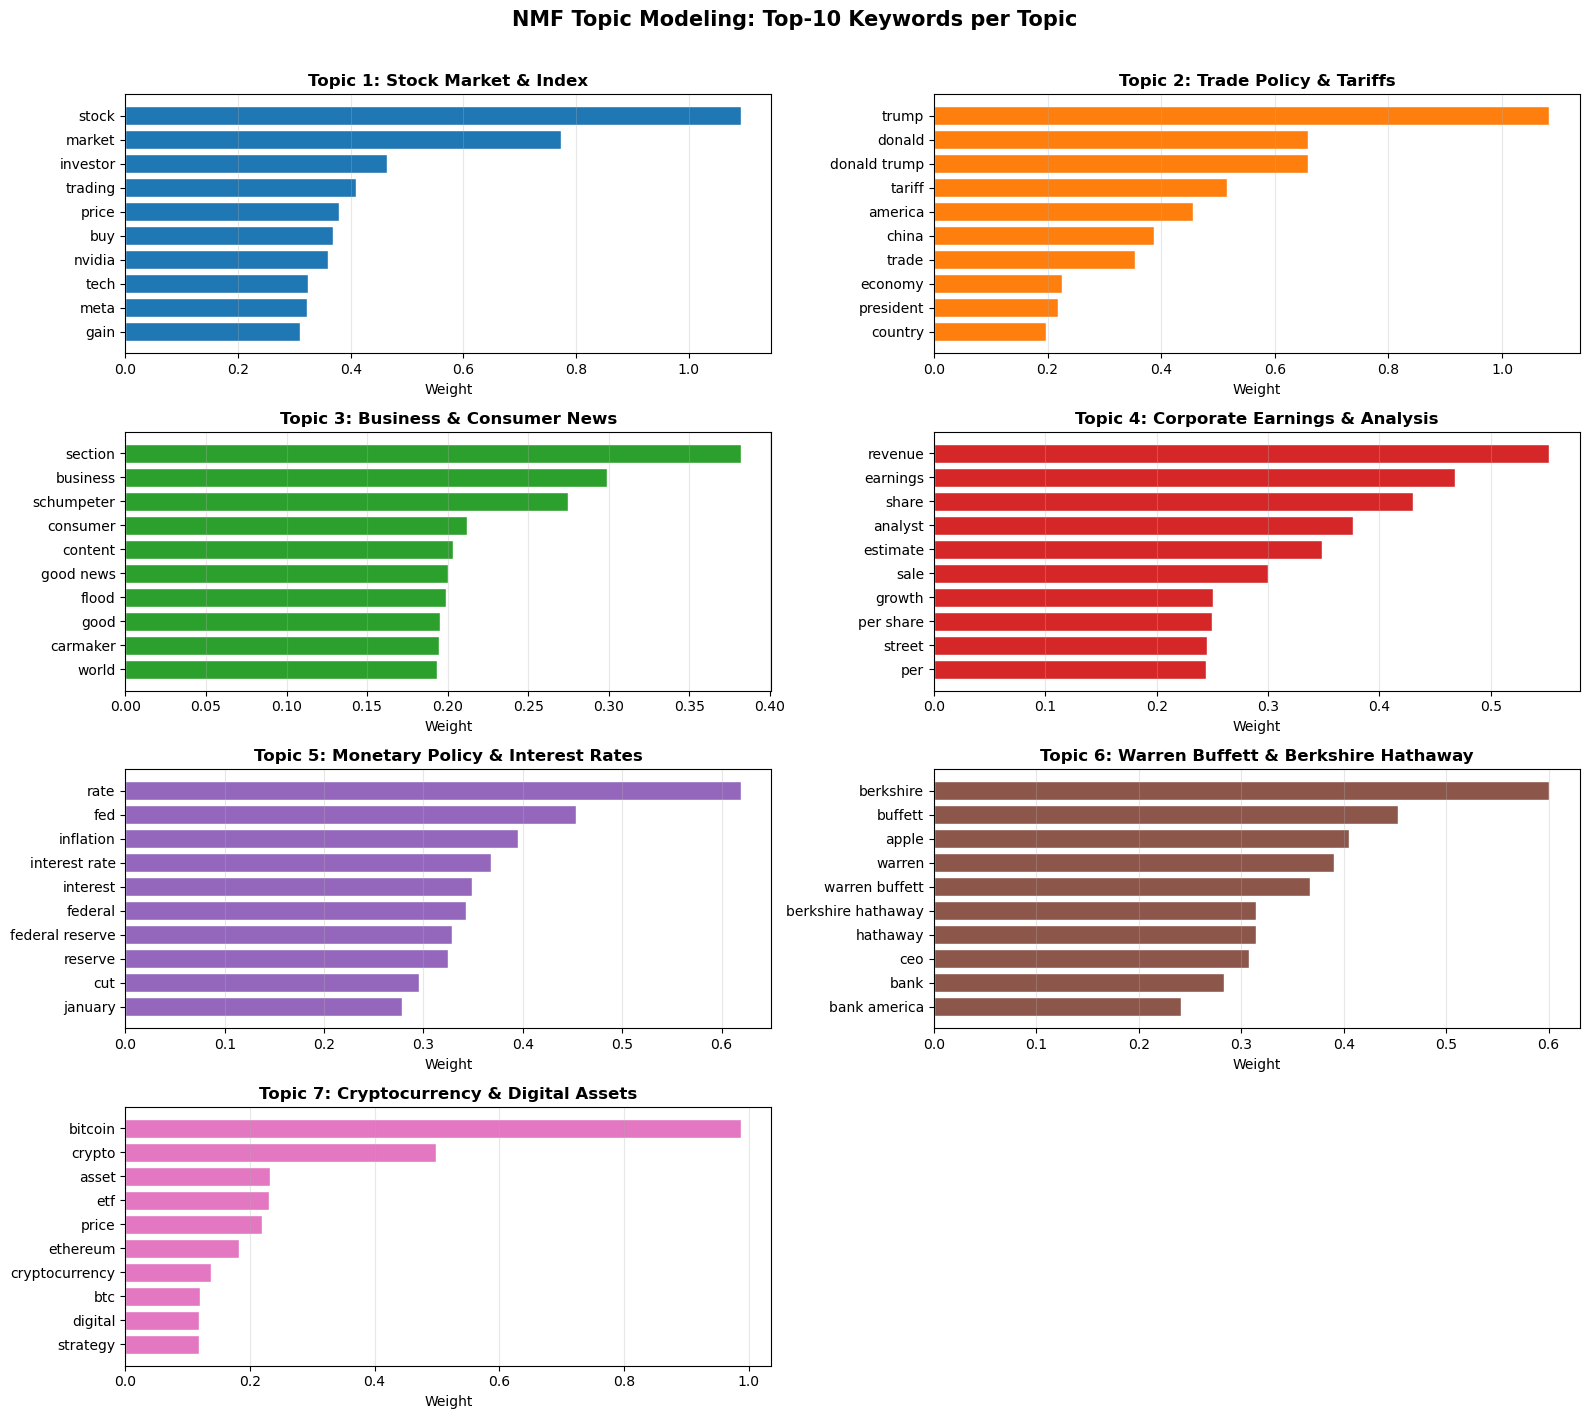

💾 บันทึกภาพเป็น nmf_topic_keywords.png


In [21]:
# สร้าง Bar Chart แสดง Top-10 คำสำคัญของแต่ละ Topic
N_TOP_WORDS_PLOT = 10
colors = cm.tab10.colors  # ชุดสีที่แตกต่างกันสำหรับแต่ละ Topic

fig, axes = plt.subplots(
    nrows=int(np.ceil(N_TOPICS / 2)),
    ncols=2,
    figsize=(16, N_TOPICS * 2)
)
axes = axes.flatten()

for topic_idx, topic_vec in enumerate(nmf_model.components_):
    # เรียงคำตาม weight
    top_indices = topic_vec.argsort()[::-1][:N_TOP_WORDS_PLOT]
    top_words   = [feature_names[i] for i in top_indices]
    top_weights = [topic_vec[i] for i in top_indices]

    # Plot bar chart (แนวนอน)
    ax = axes[topic_idx]
    bars = ax.barh(top_words[::-1], top_weights[::-1],
                   color=colors[topic_idx % len(colors)], edgecolor='white')

    # ชื่อ Topic
    label = topic_labels.get(f'Topic {topic_idx + 1}', f'Topic {topic_idx + 1}')
    ax.set_title(f'Topic {topic_idx + 1}: {label}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Weight')
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(axis='x', alpha=0.3)

# ซ่อน subplot ที่ไม่ได้ใช้ (กรณี N_TOPICS คี่)
for i in range(N_TOPICS, len(axes)):
    axes[i].set_visible(False)

plt.suptitle('NMF Topic Modeling: Top-10 Keywords per Topic',
             fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('nmf_topic_keywords.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 บันทึกภาพเป็น nmf_topic_keywords.png")

## 9. Visualization — Word Cloud แต่ละ Topic

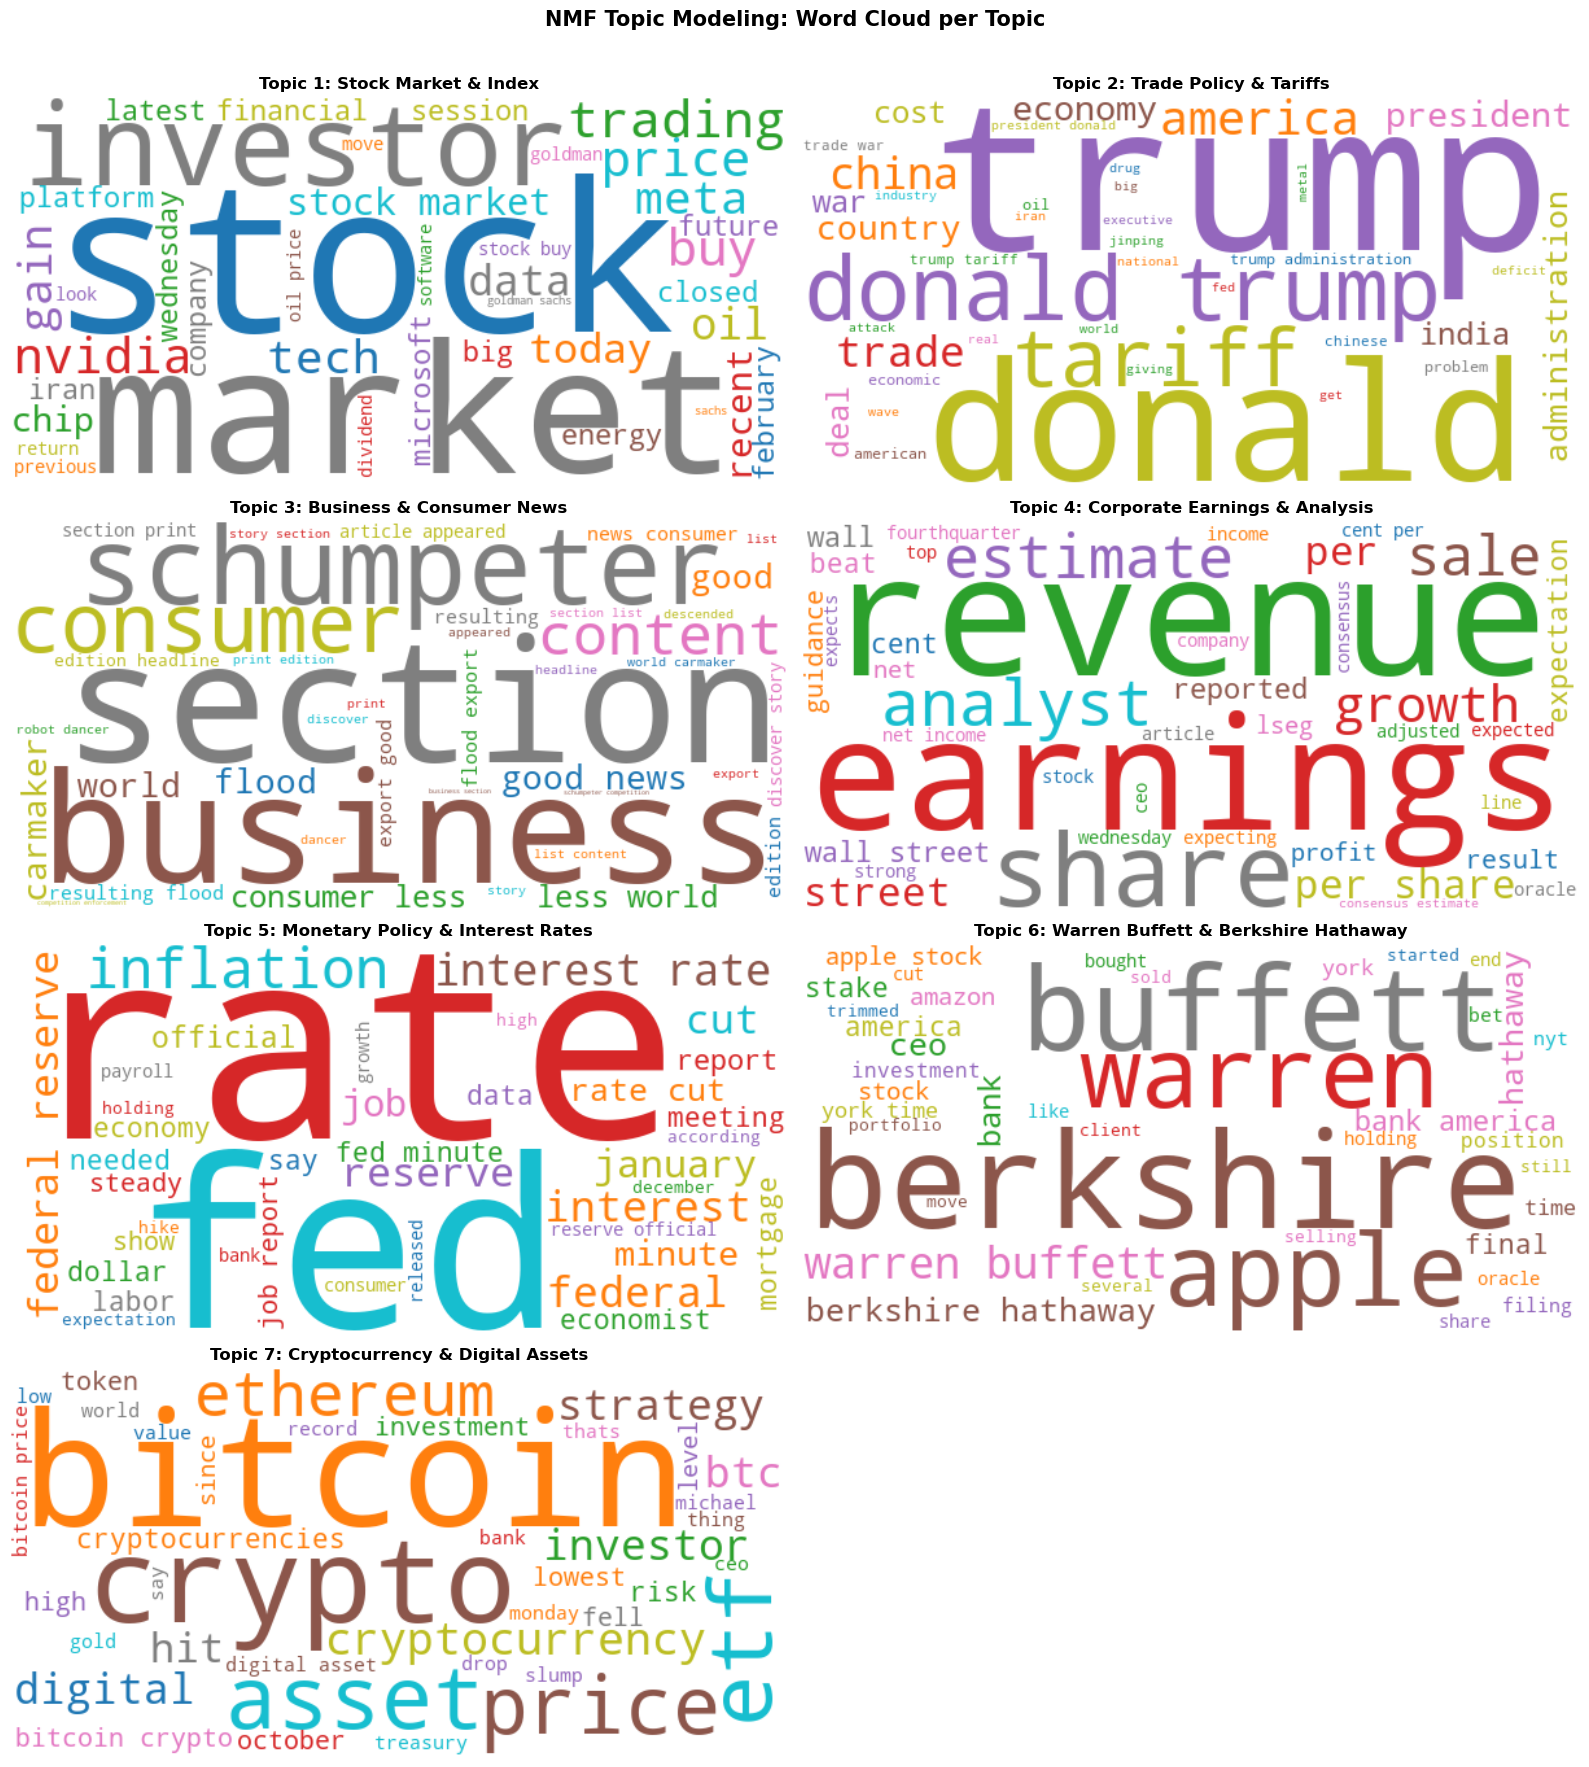

💾 บันทึกภาพเป็น nmf_wordcloud.png


In [22]:
# สร้าง Word Cloud สำหรับแต่ละ Topic
# Word Cloud แสดงคำที่มี weight สูงด้วยขนาดฟอนต์ที่ใหญ่กว่า

fig, axes = plt.subplots(
    nrows=int(np.ceil(N_TOPICS / 2)),
    ncols=2,
    figsize=(16, N_TOPICS * 2.5)
)
axes = axes.flatten()

for topic_idx, topic_vec in enumerate(nmf_model.components_):
    # สร้าง dict {word: weight} สำหรับ WordCloud
    word_weights = {
        feature_names[i]: topic_vec[i]
        for i in topic_vec.argsort()[::-1][:50]  # เอาแค่ top-50 คำ
    }

    # สร้าง WordCloud
    wc = WordCloud(
        width=600, height=300,
        background_color='white',
        colormap=f'tab10',
        max_words=40
    ).generate_from_frequencies(word_weights)

    # Plot
    ax = axes[topic_idx]
    ax.imshow(wc, interpolation='bilinear')
    label = topic_labels.get(f'Topic {topic_idx + 1}', f'Topic {topic_idx + 1}')
    ax.set_title(f'Topic {topic_idx + 1}: {label}', fontsize=12, fontweight='bold')
    ax.axis('off')

# ซ่อน subplot ที่ไม่ได้ใช้
for i in range(N_TOPICS, len(axes)):
    axes[i].set_visible(False)

plt.suptitle('NMF Topic Modeling: Word Cloud per Topic',
             fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('nmf_wordcloud.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 บันทึกภาพเป็น nmf_wordcloud.png")

## 10. กำหนด Topic ให้แต่ละ Document

In [30]:
# เลือกข้อมูลที่จะแสดง
#sample_df = df[['Sentence', 'topic_id', 'topic_label', 'topic_score']].sample(8, random_state=42)
sample_df = df[['topic_id','topic_score', 'topic_label', 'Sentence'  ]].sample(8, random_state=42)
sample_df['topic_score'] = sample_df['topic_score'].map('{:.2f}'.format)

print("ตัวอย่าง Document พร้อม Topic ที่ได้รับการกำหนด:")

# ใช้ tabulate จัดรูปแบบตาราง (headers คือส่วนหัวตาราง)
print(tabulate(sample_df, headers='keys', tablefmt='psql', showindex=False))

ตัวอย่าง Document พร้อม Topic ที่ได้รับการกำหนด:
+------------+---------------+-------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   topic_id |   topic_score | topic_label                         | Sentence                                                                                                                                                                                                                                                                                                                                                    

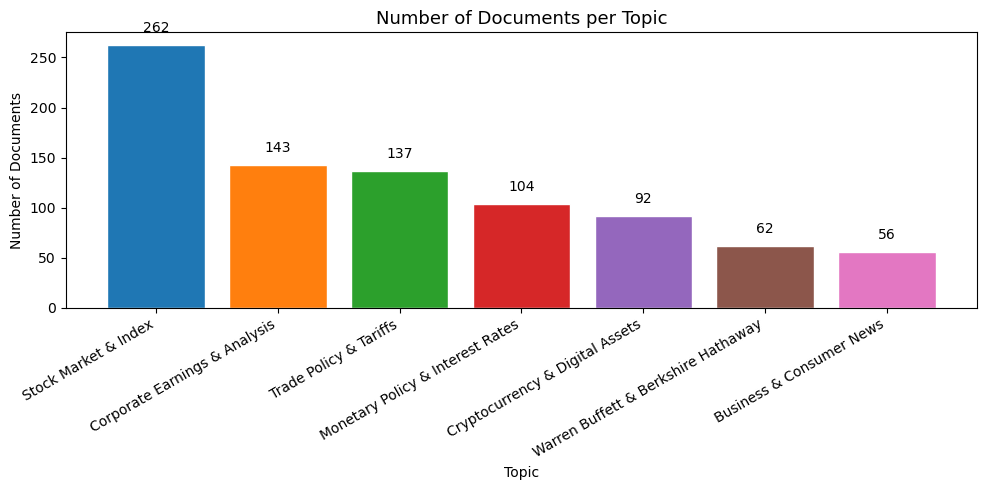

💾 Image saved as nmf_topic_distribution.png


In [31]:
# Count Documents per Topic and Plot
topic_counts = df['topic_label'].value_counts()

plt.figure(figsize=(10, 5))
bars = plt.bar(topic_counts.index, topic_counts.values,
               color=colors[:len(topic_counts)], edgecolor='white')

# Display numbers on bars
for bar, count in zip(bars, topic_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 10,
             str(count), ha='center', va='bottom', fontsize=10)

plt.title('Number of Documents per Topic', fontsize=13)
plt.xlabel('Topic')
plt.ylabel('Number of Documents')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.savefig('nmf_topic_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 Image saved as nmf_topic_distribution.png")

## 11. ตัวอย่าง Document ตัวแทนในแต่ละ Topic

ดู document ที่มี topic score สูงที่สุด เพื่อยืนยันว่า Topic นั้นถูกต้องหรือไม่

In [32]:
# แสดง document ตัวแทน (มี topic score สูงที่สุด) ของแต่ละ Topic
print("=" * 70)
print("Document ตัวแทนของแต่ละ Topic (Top-3 ที่มี Score สูงที่สุด)")
print("=" * 70)

for topic_num in sorted(df['topic_id'].unique()):
    label = topic_labels.get(f'Topic {topic_num}', f'Topic {topic_num}')
    print(f"\n🔹 Topic {topic_num}: {label}")
    print("-" * 50)

    # กรอง document ของ topic นี้ เรียงตาม score จากมากไปน้อย
    topic_docs = (
        df[df['topic_id'] == topic_num]
        .nlargest(3, 'topic_score')[['Sentence', 'topic_score']]
    )

    for _, row in topic_docs.iterrows():
        print(f"  [Score: {row['topic_score']:.4f}]")
        print(f"  {row['Sentence'][:200]}")
        print()

Document ตัวแทนของแต่ละ Topic (Top-3 ที่มี Score สูงที่สุด)

🔹 Topic 1: Stock Market & Index
--------------------------------------------------
  [Score: 0.1676]
  Transports, Apple's AI plans, oil prices: Market Takeaways. US stocks DJI, IXIC, GSPC closed Wednesday's session in positive territory the Nasdaq Composite leading the way in gains as investors ease u

  [Score: 0.1477]
  Middle Eastern Dividend Stocks Yielding Up To 7.6%. The Middle Eastern stock markets have recently experienced gains, buoyed by positive developments in U.S.-Iran talks and a rise in crude oil prices,

  [Score: 0.1466]
  Tech Stocks Set to Lead Gains Again as Oil Prices Rise. U.S. markets were headed for small gains at the open on Thursday, led by technology stocks. Eyes are on rising oil prices amid tensions between 


🔹 Topic 2: Trade Policy & Tariffs
--------------------------------------------------
  [Score: 0.3029]
  The spectacular folly of Donald Trump s copper tariffs. Duties on the red metal will

## 12. Heatmap: Document-Topic Distribution

แสดงว่า document แต่ละชุดมีความสัมพันธ์กับ topic ไหนมากน้อยแค่ไหน

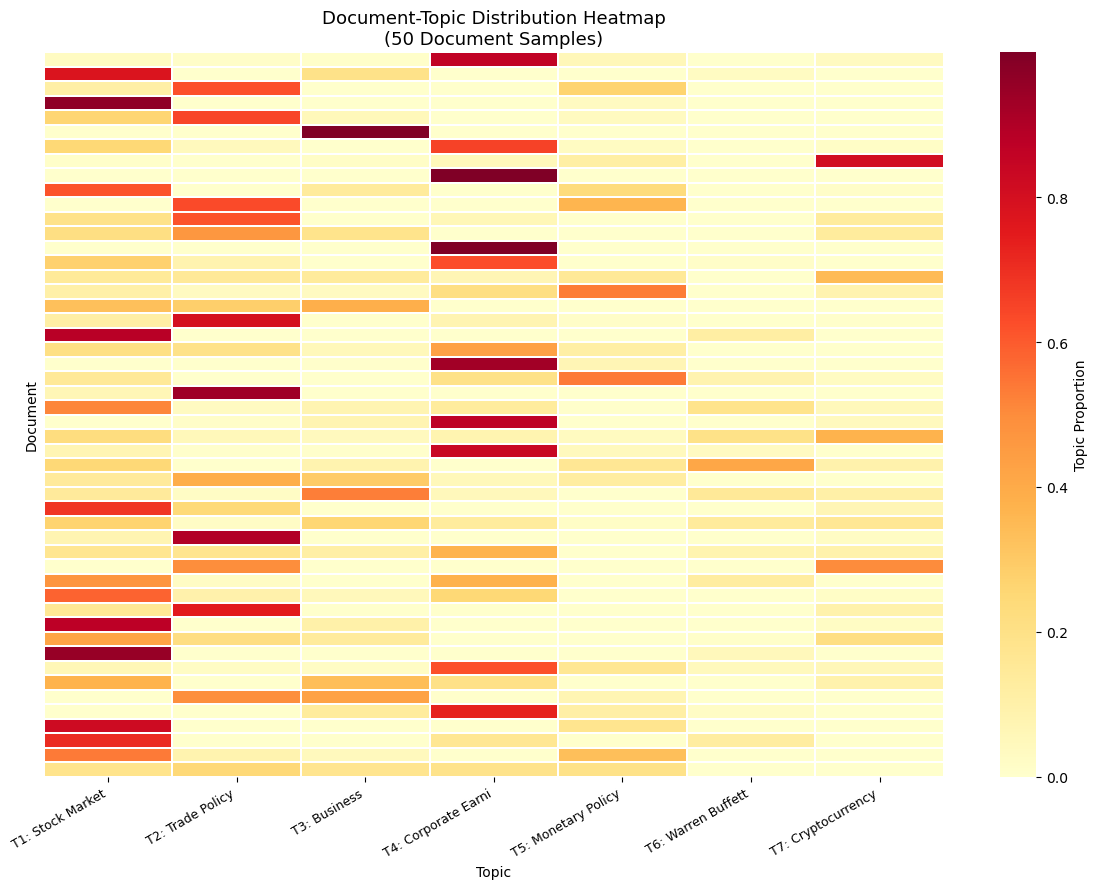

💾 Image saved as nmf_heatmap.png


In [33]:
# Randomly sample 50 documents to display in Heatmap
SAMPLE_SIZE = 50
sample_idx = np.random.choice(len(W), size=SAMPLE_SIZE, replace=False)
W_sample = W[sample_idx]

# Normalize each row to sum to 1 for easier proportion comparison
W_normalized = W_sample / (W_sample.sum(axis=1, keepdims=True) + 1e-10)

# Column names
topic_col_names = [
    f"T{i+1}: {topic_labels.get(f'Topic {i+1}', f'Topic {i+1}').split(' & ')[0][:15]}"
    for i in range(N_TOPICS)
]

plt.figure(figsize=(12, 9))
sns.heatmap(
    W_normalized,
    cmap='YlOrRd',
    xticklabels=topic_col_names,
    yticklabels=False,
    linewidths=0.1,
    cbar_kws={'label': 'Topic Proportion'}
)
plt.title(f'Document-Topic Distribution Heatmap\n({SAMPLE_SIZE} Document Samples)',
          fontsize=13)
plt.xlabel('Topic')
plt.ylabel('Document')
plt.xticks(rotation=30, ha='right', fontsize=9)
plt.tight_layout()
plt.savefig('nmf_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 Image saved as nmf_heatmap.png")

## 13. บันทึกผลลัพธ์

In [34]:
# บันทึก DataFrame ที่มี topic assignment กลับเป็น CSV
output_path = 'dataset_with_topics.csv'
df[['Sentence', 'topic_id', 'topic_label', 'topic_score']].to_csv(output_path, index=False)
print(f"💾 บันทึกผลลัพธ์เป็น {output_path}")

# บันทึกสรุป Topic Keywords
topic_summary = pd.DataFrame(topic_keywords)
topic_summary.index = [f"Rank {i+1}" for i in range(len(topic_summary))]
topic_summary.to_csv('nmf_topic_keywords.csv')
print("💾 บันทึกสรุป Keywords เป็น nmf_topic_keywords.csv")

# สรุปสถิติ
print("\n" + "=" * 50)
print("📊 สรุปผลการทำ NMF Topic Modeling")
print("=" * 50)
print(f"จำนวน Document ทั้งหมด : {len(df):,}")
print(f"จำนวน Topic            : {N_TOPICS}")
print(f"Reconstruction Error   : {nmf_model.reconstruction_err_:.4f}")
print()
print("การกระจาย Document ตาม Topic:")
for label, count in topic_counts.items():
    pct = count / len(df) * 100
    print(f"  {label:<30} {count:>5} docs ({pct:.1f}%)")

💾 บันทึกผลลัพธ์เป็น dataset_with_topics.csv
💾 บันทึกสรุป Keywords เป็น nmf_topic_keywords.csv

📊 สรุปผลการทำ NMF Topic Modeling
จำนวน Document ทั้งหมด : 856
จำนวน Topic            : 7
Reconstruction Error   : 28.0987

การกระจาย Document ตาม Topic:
  Stock Market & Index             262 docs (30.6%)
  Corporate Earnings & Analysis    143 docs (16.7%)
  Trade Policy & Tariffs           137 docs (16.0%)
  Monetary Policy & Interest Rates   104 docs (12.1%)
  Cryptocurrency & Digital Assets    92 docs (10.7%)
  Warren Buffett & Berkshire Hathaway    62 docs (7.2%)
  Business & Consumer News          56 docs (6.5%)


## 14. อภิปรายผล (Discussion)

> **คำแนะนำ:** กรอกส่วนนี้หลังจากดูผลลัพธ์จากโมเดลแล้ว

### Topic Interpretability
- **Topic ที่ตีความได้ชัดเจน:** ...
- **Topic ที่ตีความยาก:** ...
- **เหตุผลที่อาจทำให้บาง Topic ไม่ชัด:** เช่น ข้อมูลในโดเมน Finance มีคำซ้ำกันมากระหว่าง Topic

### ทำไมถึงเลือก NMF แทน LDA
- ข้อความในชุดข้อมูลนี้สั้นมาก (median ≈ 20 คำ) ทำให้ LDA ประมาณ topic distribution ได้ไม่แม่นยำ
- NMF ใช้ Matrix Factorization ซึ่งไม่ต้องการ probabilistic assumption ทำให้เหมาะกับ short text
- Topic ที่ได้จาก NMF มักคมชัดกว่า เนื่องจากค่า weight เป็น non-negative ล้วนๆ

### ข้อจำกัด
- NMF กำหนด k ล่วงหน้า ต้องทดลองหลายค่าเพื่อหา Elbow Point
- ผลลัพธ์อาจเปลี่ยนเล็กน้อยตาม random seed และวิธี initialization